### Exercise 3: Detection of Facial Key Points
The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:

    tracking faces in images and video
    analysing facial expressions
    detecting dysmorphic facial signs for medical diagnosis
    biometrics / face recognition

Detecing facial keypoints is a very challenging problem.  Facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2  
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

In [9]:
FTRAIN = '/opt/facereg-exercise/facereg-exercise/training.csv'
FTEST = '/opt/facereg-exercise/facereg-exercise/test.csv'

In [10]:
# Define the helper function for loading the data 
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [11]:
#Load and check the data
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

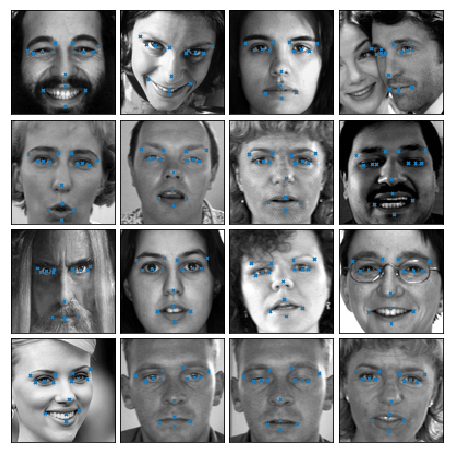

In [12]:
# Load the data and show the photoes with facial key points 
from matplotlib import pyplot 
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y[i], ax)

pyplot.show()

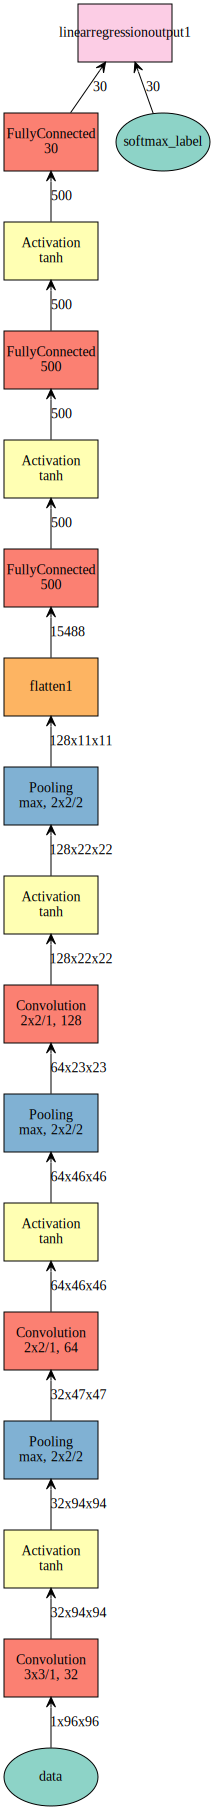

In [13]:
import mxnet as mx
import numpy as np

def mlpFacialKPnt():
    data    = mx.symbol.Variable('data')
    flatten = mx.symbol.Flatten(data=data)
    Y       = mx.symbol.Variable('softmax_label')

    fc1     = mx.symbol.FullyConnected(data=flatten, num_hidden=100)
    act1    = mx.symbol.Activation(data=fc1, act_type='relu')
    fc2     = mx.symbol.FullyConnected(data=act1, num_hidden=30)
    mlp     = mx.symbol.LinearRegressionOutput(data=fc2, label=Y)

    return mlp

def cnnFacialKPnt():

    data    = mx.symbol.Variable('data')
    Y       = mx.symbol.Variable('softmax_label')

    # first convolution
    conv1   = mx.symbol.Convolution(data=data, kernel=(3,3), num_filter=32)
    act1    = mx.symbol.Activation(data=conv1, act_type='tanh')
    pool1   = mx.symbol.Pooling(data=act1, pool_type='max',
                                kernel=(2,2), stride=(2,2))

    # second convolution
    conv2   = mx.symbol.Convolution(data=pool1, kernel=(2,2), num_filter=64)
    act2    = mx.symbol.Activation(data=conv2, act_type='tanh')
    pool2   = mx.symbol.Pooling(data=act2, pool_type='max',
                                kernel=(2,2), stride=(2,2))

    # third convolution
    conv3   = mx.symbol.Convolution(data=pool2, kernel=(2,2), num_filter=128)
    act3    = mx.symbol.Activation(data=conv3, act_type='tanh')
    pool3   = mx.symbol.Pooling(data=act3, pool_type='max',
                                kernel=(2,2), stride=(2,2))
    # first fully connected
    flatten = mx.symbol.Flatten(data=pool3)
    hidden4 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
    act4    = mx.symbol.Activation(data=hidden4,act_type='tanh')

    # second fully connected
    hidden5 = mx.symbol.FullyConnected(data=act4, num_hidden=500)
    act5    = mx.symbol.Activation(data=hidden5, act_type='tanh')

    # output layer
    output  = mx.symbol.FullyConnected(data=act5, num_hidden=30)

    # loss function
    net2    = mx.symbol.LinearRegressionOutput(data=output, label=Y)

    return net2

fkeyCNN=cnnFacialKPnt()
shape = {"data" : (200, 1, 96, 96)}
mx.viz.plot_network(symbol=fkeyCNN, shape=shape)

In [15]:
# Load, train and validate the NN model 
import mxnet as mx
from sklearn.cross_validation import train_test_split
import logging

def to4d(img):
    return img.reshape(img.shape[0], 1, 96, 96).astype(np.float32) 
#load data
# X, y = load()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)
train = mx.io.NDArrayIter(data =to4d(X_train), label = y_train, batch_size = 128)
val = mx.io.NDArrayIter(data =to4d(X_test), label = y_test, batch_size = 128)
kv = mx.kvstore.create('local')
head = '%(asctime)-15s Node[' + str(kv.rank) + '] %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)
#model

model = mx.model.FeedForward(
        ctx                = mx.cpu(), # change to mx.gpu() if GPU used 
        symbol             = fkeyCNN,
        num_epoch          = 50,
        learning_rate      = 0.01,
        momentum           = 0.9,
        #initializer        = mx.init.Xavier(factor_type="in", magnitude=2.34),
        )
model.fit(
        X                  = train,
        eval_data          = val,
        batch_end_callback = mx.callback.Speedometer(1, 50),
        epoch_end_callback = None,
        eval_metric='rmse' )

/home/lpola/.virtualenvs/cv/lib/python2.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
/home/lpola/mxnet/python/mxnet/model.py:516: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
2017-04-21 00:20:25,528 Node[0] Start training with [cpu(0)]
2017-04-21 00:21:12,711 Node[0] Epoch[0] Resetting Data Iterator
2017-04-21 00:21:12,718 Node[0] Epoch[0] Time cost=47.179
2017-04-21 00:21:26,355 Node[0] Epoch[0] Validation-rmse=0.384862
2017-04-21 00:22:12,400 Node[0] Epoch[1] Resetting Data Iterator
2017-04-21 00:22:12,407 Node[0] Epoch[1] Time cost=46.050
2017-04-21 00:22:25,547 Node[0] Epoch[1] Validation-rmse=0.371962
2017-04-21 00:23:11,981 Node[0] Epoch[2] Resetting Data Iterator
2017-04-21 00:23:11,991 Node[0] Epoch[2] Time cost=46.437
2017-04-21 00:23:25,577 Node[0] Epoch[2] Va

2017-04-21 01:01:30,137 Node[0] Epoch[40] Validation-rmse=0.089401
2017-04-21 01:02:16,891 Node[0] Epoch[41] Resetting Data Iterator
2017-04-21 01:02:16,899 Node[0] Epoch[41] Time cost=46.752
2017-04-21 01:02:29,922 Node[0] Epoch[41] Validation-rmse=0.087308
2017-04-21 01:03:15,184 Node[0] Epoch[42] Resetting Data Iterator
2017-04-21 01:03:15,192 Node[0] Epoch[42] Time cost=45.260
2017-04-21 01:03:28,517 Node[0] Epoch[42] Validation-rmse=0.085366
2017-04-21 01:04:15,002 Node[0] Epoch[43] Resetting Data Iterator
2017-04-21 01:04:15,011 Node[0] Epoch[43] Time cost=46.484
2017-04-21 01:04:27,744 Node[0] Epoch[43] Validation-rmse=0.083567
2017-04-21 01:05:15,077 Node[0] Epoch[44] Resetting Data Iterator
2017-04-21 01:05:15,081 Node[0] Epoch[44] Time cost=47.329
2017-04-21 01:05:28,573 Node[0] Epoch[44] Validation-rmse=0.081906
2017-04-21 01:06:15,132 Node[0] Epoch[45] Resetting Data Iterator
2017-04-21 01:06:15,138 Node[0] Epoch[45] Time cost=46.556
2017-04-21 01:06:28,797 Node[0] Epoch[45

In [16]:
#Save and load the model
prefix = 'facialkeyModel'
iteration = 50
model.save(prefix)
model_loaded = mx.model.FeedForward.load(prefix, iteration)  


2017-04-21 07:27:52,465 Node[0] Saved checkpoint to "facialkeyModel-0050.params"
/home/lpola/mxnet/python/mxnet/model.py:870: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  **kwargs)


[329, 504, 424, 539, 303, 272, 682, 580, 8]


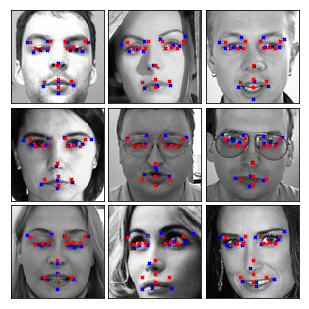

In [49]:
# Visualize the predicted points of some sample photoes and compare them with actual points 
import random 

pnum=9 
index=[random.randint(0,len(X_test)) for i in range(pnum)]
print(index)
yvalPred=model_loaded.predict(to4d(X_test[index]))


def plot_sample2(x, y,yval, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10,color='blue')
    axis.scatter(yval[0::2] * 48 + 48, yval[1::2] * 48 + 48, marker='x', s=10,color='red')

fig = pyplot.figure(figsize=(4, 4))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(pnum):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_sample2(X_test[index[i]], y_test[index[i]],yvalPred[i], ax)
